In [1]:
import abc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import datetime
import pandas as pd

In [2]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
               'horse', 'ship', 'truck']

In [3]:
class CNNModel(tf.keras.Model):
    def __init__(self, kernel_size, pool_size, pooling=tf.keras.layers.MaxPool2D):
        """Inits the class."""
        super(CNNModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=kernel_size, 
                                            strides=(1,1), use_bias=True,
                                            input_shape=(32, 32, 3)
                                            )
        self.pool1 = pooling(pool_size=pool_size, strides=(2,2))
        
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=kernel_size, 
                                            strides=(1,1), use_bias=True)
        self.pool2 = pooling(pool_size=pool_size, strides=(2,2))
        
        self.flatten = tf.keras.layers.Flatten()
        
        self.fc1 = tf.keras.layers.Dense(units=384)
        self.fc2 = tf.keras.layers.Dense(units=192)
        self.fc3 = tf.keras.layers.Dense(units=10)

    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = self.conv1(inputs)
        x = tf.keras.activations.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = tf.keras.activations.relu(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = tf.keras.activations.relu(x)
        
        x = self.fc2(x)
        x = tf.keras.activations.relu(x)
        
        x = self.fc3(x)
        x = tf.keras.activations.softmax(x)
        
        return x

    def fit(self, **kwargs):
        """Implements learning loop for the model.
        
        kwargs can contain optional parameters such as 
        num_epochs, batch_size, etc.
        """
        self.epoch_loss = []
        self.epoch_accuracy = []
        self.epoch_fscore = []
        self.epoch_time = []
        
        x_train, y_train, epochs, batch_size, cost_func, learning_coef, optimizer = self._get_params(**kwargs)
        
        optimizer = optimizer(learning_rate=learning_coef)
        train_dataset = self._extract_train_dataset(x_train, y_train, batch_size)

        for epoch in range(epochs):
            start = datetime.datetime.now()
            epoch_acc = tf.keras.metrics.SparseCategoricalAccuracy()

            for x, y in train_dataset:
                x = tf.dtypes.cast(x, tf.float32)
                y = tf.dtypes.cast(y, tf.float32)

                with tf.GradientTape() as tape:
                    logits = self.call(x)
                    loss_value = cost_func(y, logits)

                grads = tape.gradient(loss_value, self.trainable_variables)
                optimizer.apply_gradients(zip(grads, self.trainable_variables))

                epoch_acc.update_state(y, logits)
                self.epoch_loss.append(loss_value)
                
            end = datetime.datetime.now()
            diff = end - start
            self.epoch_time.append(diff.total_seconds())
            
            self.epoch_accuracy.append(epoch_acc.result().numpy())

            print("Epoch {:02d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                        self.epoch_loss[-1], 
                                                                        self.epoch_accuracy[-1]))

    def predict(self, x):
        """Predicts outputs based on inputs (x)."""
        x_dataset = self._extract_test_dataset(x, batch_size=1000)
        prediction = []
        for x in x_dataset:
            logits = self.call(x)
            prediction.extend(tf.argmax(logits, axis=1, output_type=tf.int32))
        return prediction
    
    def _extract_train_dataset(self, x_train, y_train, batch_size):
        x_train = self._preprocess_x(x_train)
      
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size=batch_size)
        return train_dataset
    
    def _extract_test_dataset(self, x_train, batch_size):
        x_train = self._preprocess_x(x_train)
      
        train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
        train_dataset = train_dataset.batch(batch_size=batch_size)
        return train_dataset
    
    def _preprocess_x(self, x_set):
        x_set = x_set / 255.0
        return x_set
    
    def _get_params(self, **kwargs):
        x_train = kwargs.get('x', None)
        y_train = kwargs.get('y', None)
        epochs = kwargs.get('epochs', 10)
        batch_size = kwargs.get('batch_size', 100)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        learning_coef = kwargs.get('learning_coef', 0.001)
        optimizer = kwargs.get('optimizer', tf.keras.optimizers.Adam)
        return x_train, y_train, epochs, batch_size, cost_func, learning_coef, optimizer


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
def plot_confusion_matrix(x_test, y_pred):
    conf_matrix = tf.math.confusion_matrix(y_pred, y_test).numpy()
    conf_matrix = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

    fig, ax = plt.subplots(figsize=(10,10))   
    ax = sns.heatmap(conf_matrix, cmap="PiYG", annot=True, center=0)
    ax.yaxis.set_ticklabels(CLASS_NAMES, rotation=0, ha='right', fontsize=14)
    ax.xaxis.set_ticklabels(CLASS_NAMES, rotation=45, ha='right', fontsize=14)
    

# y_pred = model.predict(x_test)
# plot_confusion_matrix(x_test, y_pred)

In [6]:
def get_wrongly_classified_images(x_test, y_pred, y_test):
    images = []
    labels_pred = []
    labels_real = []
    classes = {}
    for i in range(10):
        classes[i] = 0

    for image, pred, real in zip(x_test, y_pred, y_test):
        if pred != real and classes[real.item()] < 3:
            images.append(image)
            labels_pred.append(pred)
            labels_real.append(real.item())
            classes[real.item()] += 1
    return images, labels_pred, labels_real

def show_images(images, labels_pred, labels_real):
    labels_real, labels_pred, images = zip(*sorted(zip(labels_real, labels_pred, images), key=lambda tup: tup[0]))
    fig = plt.figure(figsize=(7,9))
    fig.subplots_adjust(wspace=1.4, hspace=1)
    for n in range(30):
        ax = plt.subplot(10, 3, n+1)
        plt.imshow(images[n])
        title = str(CLASS_NAMES[labels_real[n]]) + '/' + str(CLASS_NAMES[labels_pred[n]])
        plt.title(title, fontsize = 10)
        plt.axis('off')
        
# images, labels_pred, labels_real = get_wrongly_classified_images(x_test, y_pred, y_test)
# show_images(images, labels_pred, labels_real)

In [7]:
def visualize(model, x_test, y_test):
    fig, ax = plt.subplots()
    plt.plot(model.epoch_loss)
    ax.set_title('Epoch loss')
    plt.show()
    plt.clf()
    
    fig, ax = plt.subplots()
    plt.plot(model.epoch_accuracy)
    ax.set_title('Epoch accuracy')
    plt.show()
    plt.clf()
    
    fig, ax = plt.subplots()
    plt.plot(model.epoch_time)
    ax.set_title('Epoch time')
    plt.show()
    plt.clf()
    
    y_pred = model.predict(x_test)
    plot_confusion_matrix(x_test, y_pred)
    images, labels_pred, labels_real = get_wrongly_classified_images(x_test, y_pred, y_test)
    show_images(images, labels_pred, labels_real)

In [8]:
batch_size = 100
learning_coef = 0.01  # 0.01
epochs = 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD


def test_params_base(batch_size, learning_coef, epochs, cost_func, optimizer,
                     kernel_size, pool_size, pooling,
                     x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    model = CNNModel(kernel_size=kernel_size, pool_size=pool_size, pooling=pooling)
    
    print("Started fitting")

    model.fit(x=x_train, y=y_train, batch_size=batch_size, learning_coef=learning_coef, 
             epochs=epochs, cost_func=cost_func, optimizer=optimizer)
    
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    loss = model.epoch_loss[-1]
    return model, acc, f1, loss.numpy()

In [9]:
# %%time
# 
# batch_size = 100
# learning_coef = 0.001  # 0.01
# epochs = 10
# cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam
# kernel_size = (3, 3)  # TODO: 5, 5
# pool_size = (2, 2)  # TODO: 3, 3
# pooling = tf.keras.layers.MaxPool2D
# 
# 
# results = test_params_base(batch_size=batch_size, learning_coef=learning_coef, 
#                            epochs=epochs, cost_func=cost_func, 
#                            optimizer=optimizer, kernel_size=kernel_size, 
#                            pool_size=pool_size, pooling=pooling)
# model, acc, f1, loss = results
# res_df = pd.DataFrame(columns=['batch_size', 'learning_coef', 'epochs', 
#                                'cost_func', 'optimizer', 'kernel_size', 
#                                'pool_size', 'pooling', 'acc', 'f1', 'loss', 'time'])
# res_df = res_df.append({'batch_size': batch_size, 'learning_coef': learning_coef,
#                         'epochs': epochs, 'cost_func': type(cost_func).__name__, 
#                         'optimizer': optimizer.__name__, 
#                         'kernel_size': kernel_size, 'pool_size': pool_size, 
#                         'pooling': pooling.__name__, 
#                         'acc': acc, 'f1': f1, 'loss': loss, 
#                         'time': sum(model.epoch_time)}, 
#                        ignore_index=True)
# 
# with open('results.csv', 'a') as f:
#     res_df.to_csv(f, header=False)

In [10]:
%%time

batch_size = 100
learning_coef = 0.001
epochs = 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam
kernel_size = (3, 3)
pool_size = (3, 3)
pooling = tf.keras.layers.MaxPooling2D

exp_kernel_size = [(7, 7), (5,5), (3,3)]
exp_pool_size = [(4, 4), (3, 3), (2, 2)]
exp_pooling = [tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D]

for pooling in exp_pooling:
    for pool_size in exp_pool_size:
        for kernel_size in exp_kernel_size:
            results = test_params_base(batch_size=batch_size, learning_coef=learning_coef, 
                                       epochs=epochs, cost_func=cost_func, 
                                       optimizer=optimizer, kernel_size=kernel_size, 
                                       pool_size=pool_size, pooling=pooling)
            model, acc, f1, loss = results
            time = sum(model.epoch_time)
            res_df = pd.DataFrame(columns=['batch_size', 'learning_coef', 'epochs', 
                                           'cost_func', 'optimizer', 'kernel_size', 
                                           'pool_size', 'pooling', 'acc', 'f1', 'loss', 'time'])
            res_df = res_df.append({'batch_size': batch_size, 'learning_coef': learning_coef,
                                    'epochs': epochs, 'cost_func': type(cost_func).__name__, 
                                    'optimizer': optimizer.__name__, 
                                    'kernel_size': kernel_size, 'pool_size': pool_size, 
                                    'pooling': pooling.__name__, 
                                    'acc': acc, 'f1': f1, 'loss': loss, 
                                    'time': time}, 
                                   ignore_index=True)
            with open('results.csv', 'a') as f:
                res_df.to_csv(f, header=False)

Started fitting
Epoch 00: Loss: 1.267, Accuracy: 38.328%
Epoch 01: Loss: 1.256, Accuracy: 51.914%
Epoch 02: Loss: 1.189, Accuracy: 57.252%
Epoch 03: Loss: 1.289, Accuracy: 60.958%
Epoch 04: Loss: 0.959, Accuracy: 63.536%
Epoch 05: Loss: 0.966, Accuracy: 65.156%
Epoch 06: Loss: 0.916, Accuracy: 67.148%
Epoch 07: Loss: 0.838, Accuracy: 68.058%
Epoch 08: Loss: 0.782, Accuracy: 69.026%
Epoch 09: Loss: 0.697, Accuracy: 70.616%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Started fitting
Epoch 00: Loss: 1.447, Accuracy: 39.982%
Epoch 01: Loss: 1.206, Ac

In [19]:
results_params = pd.read_csv('results.csv')
results = results_params.loc[results_params['acc'].idxmax()][['batch_size', 'learning_coef', 'epochs', 
                                           'cost_func', 'optimizer', 'kernel_size', 
                                           'pool_size', 'pooling']]
print(results)
batch_size, learning_coef, epochs, cost_func, optimizer, kernel_size, \
    pool_size, pooling = results
optimizer = tf.keras.optimizers.Adam if optimizer == 'Adam' else tf.keras.optimizers.SGD
cost_func = tf.keras.losses.SparseCategoricalCrossentropy() if \
    cost_func == 'SparseCategoricalCrossentropy' else None
pooling = tf.keras.layers.MaxPooling2D if pooling == 'MaxPooling2D' \
    else tf.keras.layers.AveragePooling2D if pooling == 'AveragePooling2D' else None
kernel_size =  [int(el) for el in kernel_size.split('(')[1].split(')')[0].split(',')]
pool_size =  [int(el) for el in pool_size.split('(')[1].split(')')[0].split(',')]
print(batch_size, learning_coef, epochs, cost_func, optimizer, kernel_size, 
      pool_size, pooling)

batch_size                                 100
learning_coef                            0.001
epochs                                      10
cost_func        SparseCategoricalCrossentropy
optimizer                                 Adam
kernel_size                             (3, 3)
pool_size                               (4, 4)
pooling                           MaxPooling2D
Name: 2, dtype: object
100 0.001 10 <tensorflow.python.keras.losses.SparseCategoricalCrossentropy object at 0x0000000018C0FBA8> <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> [3, 3] [4, 4] <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>


In [20]:
results_params

,Unnamed: 0,batch_size,learning_coef,epochs,cost_func,optimizer,kernel_size,pool_size,pooling,acc,f1,loss,time
0,0,100,0.001,10,SparseCategoricalCrossentropy,Adam,"(7, 7)","(4, 4)",MaxPooling2D,0.6749,0.6749,0.697371,726.064528
1,0,100,0.001,10,SparseCategoricalCrossentropy,Adam,"(5, 5)","(4, 4)",MaxPooling2D,0.6755,0.6755,0.655939,713.360802
2,0,100,0.001,10,SparseCategoricalCrossentropy,Adam,"(3, 3)","(4, 4)",MaxPooling2D,0.7556,0.7556,0.400648,690.874514
3,0,100,0.001,10,SparseCategoricalCrossentropy,Adam,"(7, 7)","(3, 3)",MaxPooling2D,0.6456,0.6456,0.956642,708.785541
4,0,100,0.001,10,SparseCategoricalCrossentropy,Adam,"(5, 5)","(3, 3)",MaxPooling2D,0.7165,0.7165,0.472619,701.999151
5,0,100,0.001,10,SparseCategoricalCrossentropy,Adam,"(3, 3)","(3, 3)",MaxPooling2D,0.7166,0.7166,0.421716,670.959375
6,0,100,0.001,10,SparseCategoricalCrossentropy,Adam,"(7, 7)","(2, 2)",MaxPooling2D,0.6188,0.6188,0.802184,765.866806
7,0,100,0.001,10,SparseCategoricalCrossentropy,Adam,"(5, 5)","(2, 2)",MaxPooling2D,0.6817,0.6817,0.378007,768.519957
8,0,100,0.001,10,SparseCategoricalCrossentropy,Adam,"(3, 3)","(2, 2)",MaxPooling2D,0.7097,0.7097,0.496471,755.402206
9,0,100,0.001,10,SparseCategoricalCrossentropy,Adam,"(7, 7)","(4, 4)",AveragePooling2D,0.5961,0.5961,0.957555,752.213024


In [12]:
results = test_params_base(batch_size=batch_size, learning_coef=learning_coef, 
                           epochs=epochs, cost_func=cost_func, 
                           optimizer=optimizer, kernel_size=kernel_size, 
                           pool_size=pool_size, pooling=pooling)
model, acc, f1, loss = results

Started fitting
Epoch 00: Loss: 1.132, Accuracy: 47.076%
Epoch 01: Loss: 1.024, Accuracy: 62.212%
Epoch 02: Loss: 0.978, Accuracy: 67.656%
Epoch 03: Loss: 0.859, Accuracy: 71.166%
Epoch 04: Loss: 0.849, Accuracy: 74.578%
Epoch 05: Loss: 0.613, Accuracy: 76.662%
Epoch 06: Loss: 0.548, Accuracy: 78.280%
Epoch 07: Loss: 0.532, Accuracy: 80.320%
Epoch 08: Loss: 0.565, Accuracy: 81.906%
Epoch 09: Loss: 0.463, Accuracy: 83.526%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



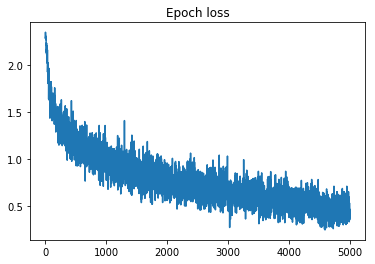

<Figure size 432x288 with 0 Axes>

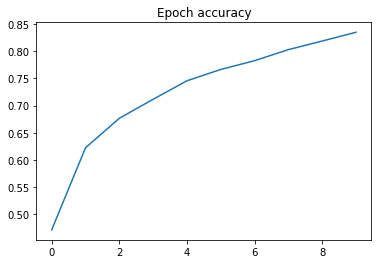

<Figure size 432x288 with 0 Axes>

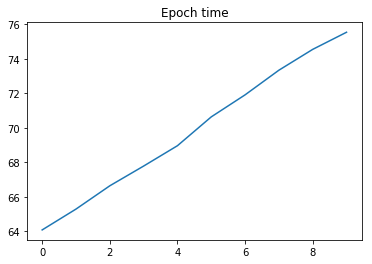

<Figure size 432x288 with 0 Axes>

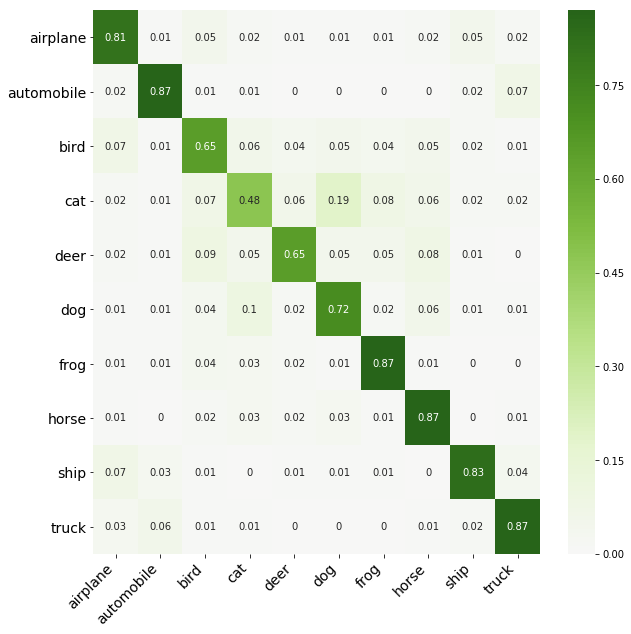

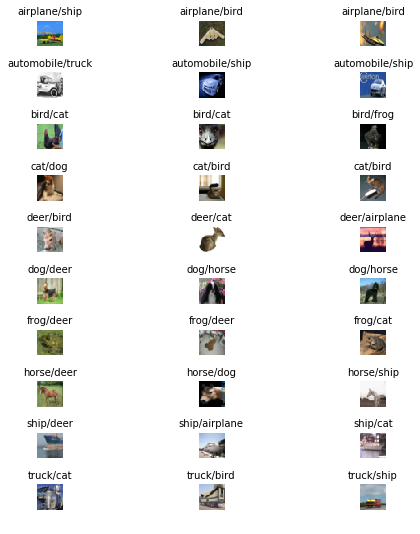

In [13]:
visualize(model, x_test, y_test)

In [21]:
def plot_tests(df, test):
    test_groupby = test[0]
    test_x = test[1]

    scores = ['acc', 'f1', 'time']

    for score in scores:
        fig, ax = plt.subplots(figsize=(15, 10))
        for key, grp in df.groupby(test_groupby):
            ax = grp.plot(ax=ax, kind='line', x=test_x, y=score, label=key, style='.-',
                          title='{}'.format(score))
        plt.show()
        plt.clf()

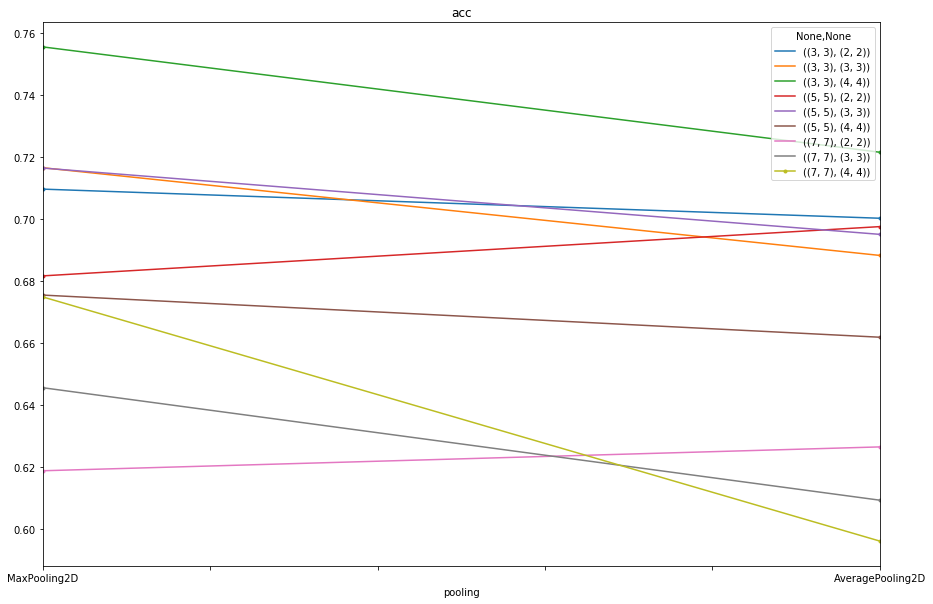

<Figure size 432x288 with 0 Axes>

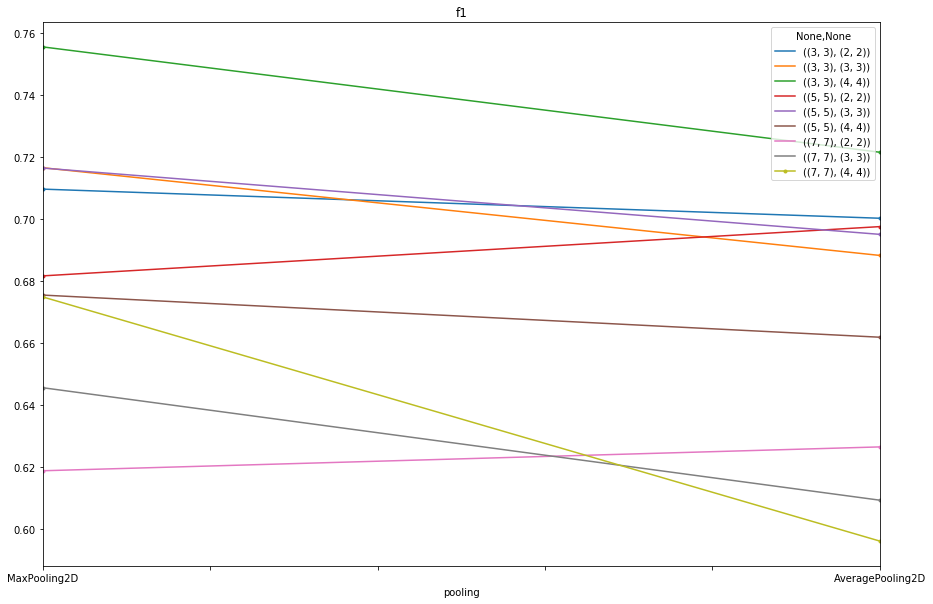

<Figure size 432x288 with 0 Axes>

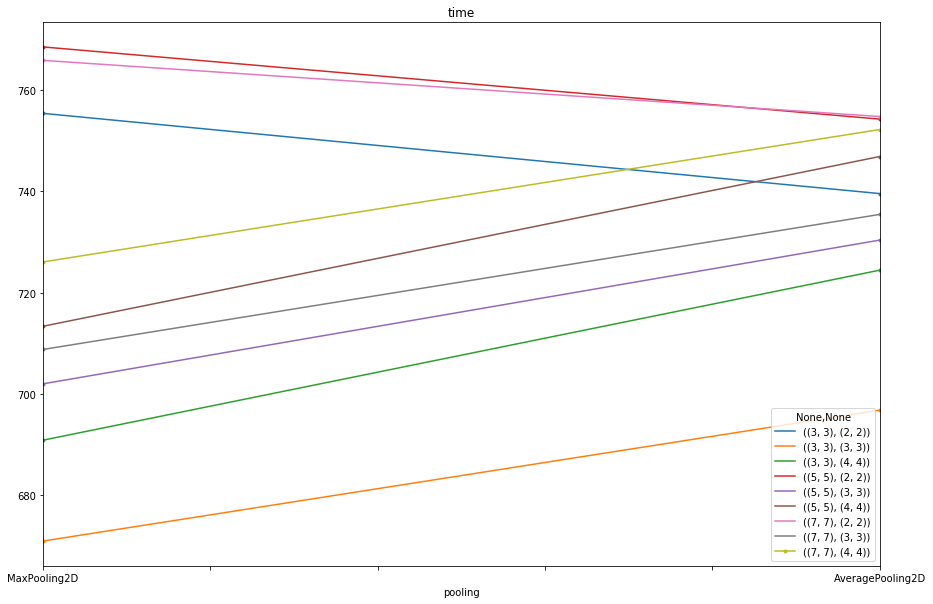

<Figure size 432x288 with 0 Axes>

In [22]:
tests_params = [(['kernel_size', 'pool_size'], 'pooling'), (['kernel_size', 'pooling'], 'pool_size'), 
         (['pool_size', 'pooling'], 'kernel_size')]
plot_tests(results_params, tests_params[0])

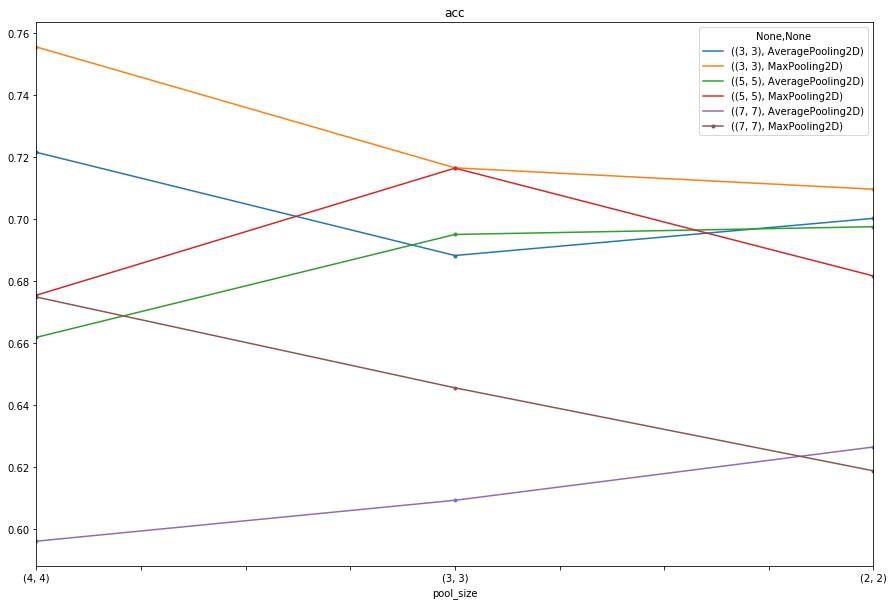

<Figure size 432x288 with 0 Axes>

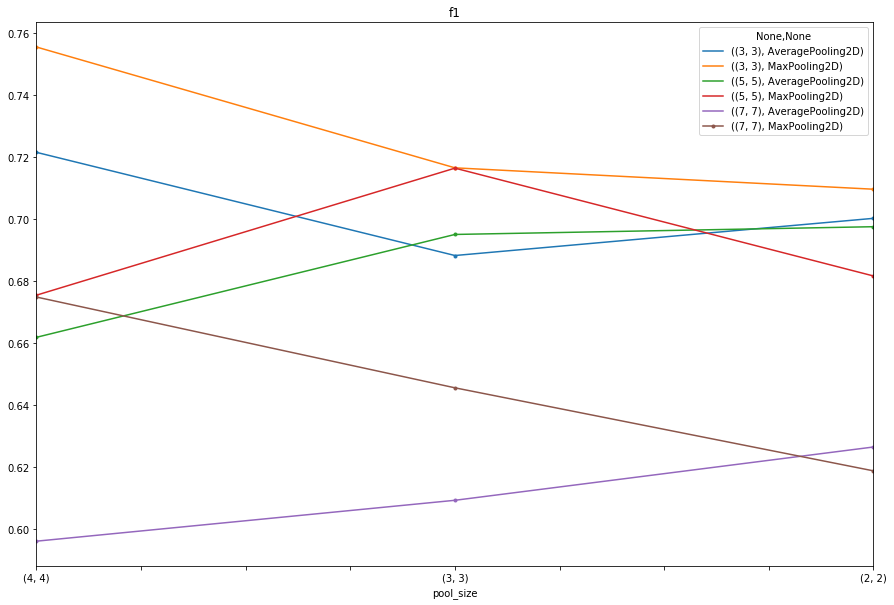

<Figure size 432x288 with 0 Axes>

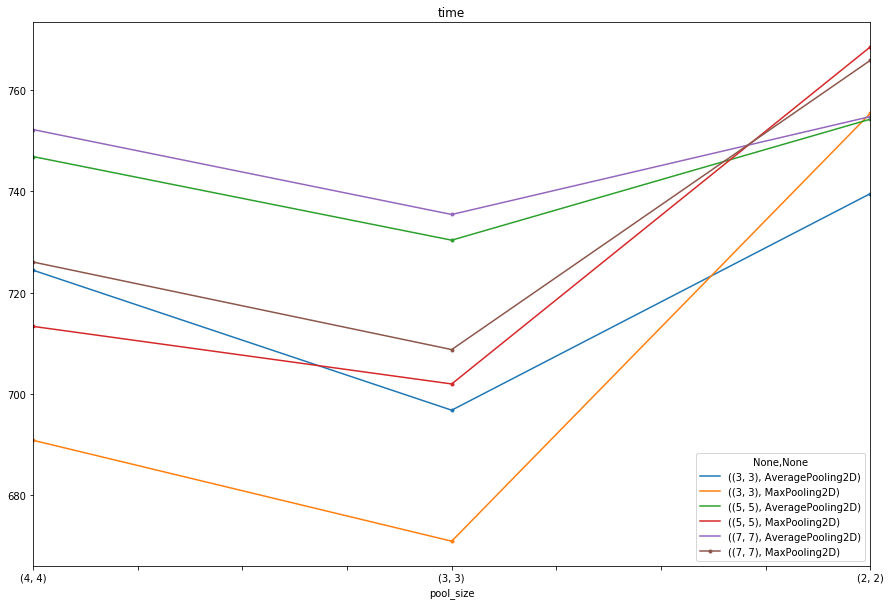

<Figure size 432x288 with 0 Axes>

In [23]:
plot_tests(results_params, tests_params[1])

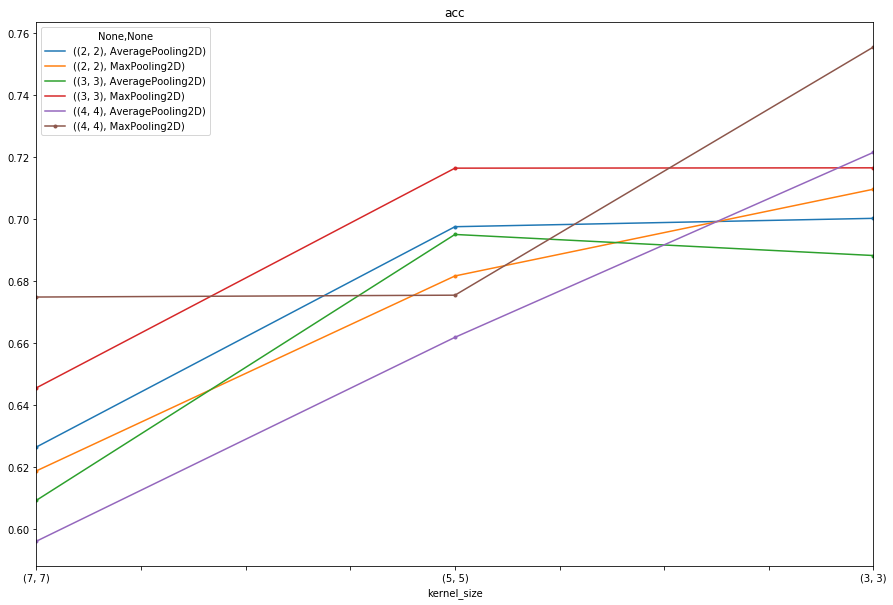

<Figure size 432x288 with 0 Axes>

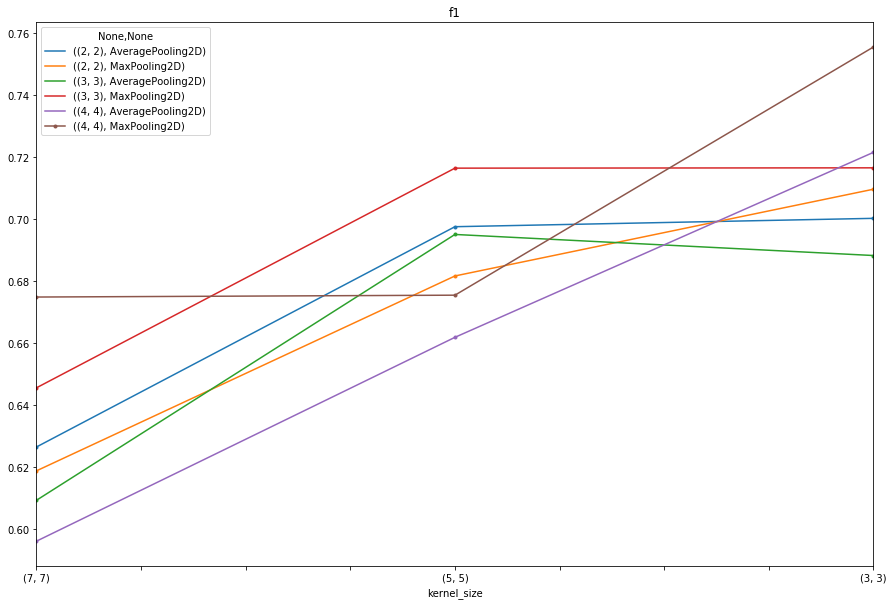

<Figure size 432x288 with 0 Axes>

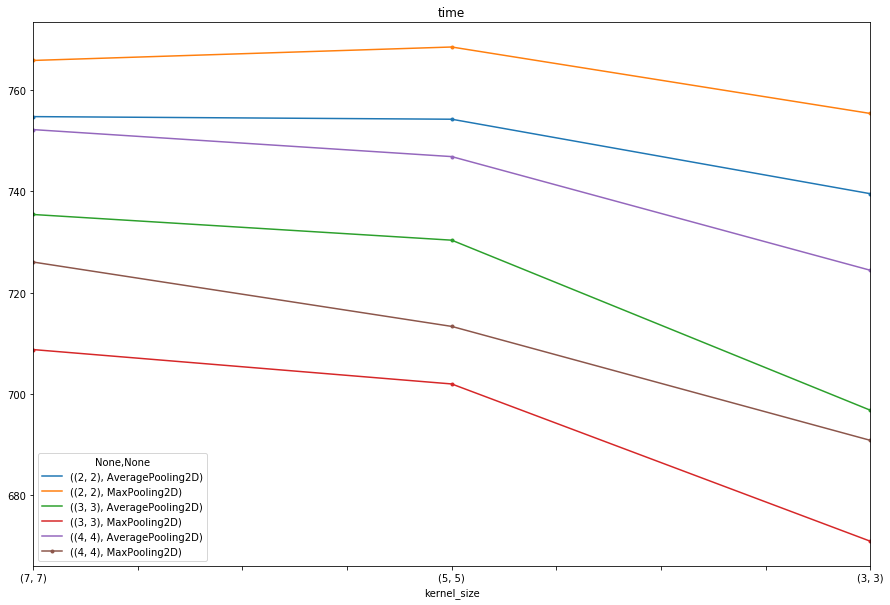

<Figure size 432x288 with 0 Axes>

In [24]:
plot_tests(results_params, tests_params[2])